# **TP3 : Analyse par Composantes Principales appliquée à la réduction de dimensionnalité**


# Context & Objectives

This TP aims to make you more familiar with one of the most famous unsupervised machine learning methods called **PCA**, standing for Principal Component Analysis. Its main applications are:
*   dimensionality reduction
*   clustering analysis
*   feature extraction (which can be used as low-dimension inputs of a classifier)

In this TP, we will explore PCA for dimensionality reduction.

In [48]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

# 1. Starting with PCA: from maths to codes on a toy example

## Principle


Mathematically, PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on. A principal component is thus a linear combination of the variables maximizing the variance. 

Considering a ${\displaystyle n\times p}$ data matrix $\boldsymbol{\bar{X}}$, with column-wise zero empirical mean (i.e. the sample mean of each column has been shifted to zero), where each of the $n$ rows represents a different observation, and each of the $p$ columns a particular feature. The full principal components decomposition of $\boldsymbol{\bar{X}}$ can be given as

$$\boldsymbol{T} = \boldsymbol{\bar{X}} \boldsymbol{W}$$

where $\boldsymbol{W}$ is a ${\displaystyle p \times l}$ matrix equal to $[ \boldsymbol{w^{(1)}} , \cdots , \boldsymbol{w^{(l)}} ]$. Those are the PCA basis vectors. By definition, the $k^{th}$ principal component $\boldsymbol{w^{(k)}} = [ w_1^{(k)} , \cdots , w_p^{(k)} ]^T$ is defined as equal to the $k^{th}$ eigenvector of the matrix $\boldsymbol{\bar{X}^T} \boldsymbol{\bar{X}}$. This latter can be recognised as proportional to the empirical sample covariance matrix of $\boldsymbol{\bar{X}}$. 

Thus, using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance. 

## 1. Step-by-step covariance method to compute PCA

**Step 1.1 : dataset generation and normalization** 

Let's consider in the code cell below the 2D feature matrix **X** (variable `X`) composed of two correlated normal random variables $X_1$ and $X_2$. Create and plot the normalized matrix $\boldsymbol{\bar{X}}$ by subtracting to each feature its empirical mean value.


In [49]:
np.random.seed(123)

n = 500

x1 = 10 * np.random.rand(n)
x2 = x1 + np.random.randn(n) + 1

X = np.hstack([x1.reshape(n, 1), x2.reshape(n, 1) ])

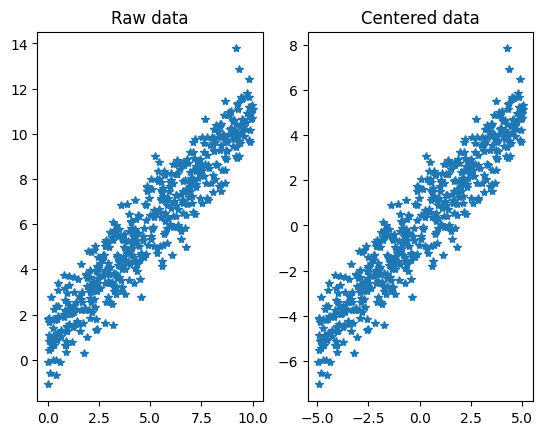

In [50]:
def centerData(X):
    return X - X.mean(axis=0)

X_centered = centerData(X)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(X[:,0], X[:,1], '*')
ax1.title.set_text('Raw data')
ax2.plot(X_centered[:,0], X_centered[:,1], '*')
ax2.title.set_text('Centered data')
plt.show()

**Step 1.2 : Covariance matrix**

Compute the empirical covariance matrix $\boldsymbol{C}$ given by:

$$\boldsymbol{C} = \frac{1}{n-1} \boldsymbol{\bar{X}}^{T} \boldsymbol{\bar{X}} $$

In [51]:
cov_mat = 1 / (X.shape[0] - 1) * X_centered.T @ X_centered
print(cov_mat)

[[8.19654406 8.28913321]
 [8.28913321 9.40995916]]


**Step 1.3 : Eigenvectors and eigenvalues of the covariance matrix** 

Compute the eigenvectors and eigenvalues of $\boldsymbol{C}$, and sort the columns of the eigenvector matrix and eigenvalue matrix in order of decreasing eigenvalues. 

*tips* : use `np.linalg.eig()`, `.argsort()[::-1]`

In [52]:
eigVals, eigVecs = np.linalg.eig(cov_mat)

sorted_eigVals = eigVals[eigVals.argsort()[::-1]]
sorted_eigVecs = eigVecs[:, eigVals.argsort()[::-1]]

print("1e vp : " + str(sorted_eigVals[0]) + " 1e Vecteur propre : " + str(sorted_eigVecs[:,0]))
print("2e vp : " + str(sorted_eigVals[1]) + " 2e Vecteur propre : " + str(sorted_eigVecs[:,1]) )

1e vp : 17.114558575654925 1e Vecteur propre : [-0.68080913 -0.73246087]
2e vp : 0.4919446434732606 2e Vecteur propre : [-0.73246087  0.68080913]


**Step 1.4 : Ratio of explained variance** 

Let's define $\boldsymbol{D} = \boldsymbol{V^{-1}} \boldsymbol{C} \boldsymbol{V}$ the diagonal matrix of eigenvalues of $\boldsymbol{C}$, where $\boldsymbol{V}$ is the matrix of eigenvectors.

We define the ratio of explained variance $g_j$ for the eigenvector $j$ as:

\begin{equation}
g_j = \frac{ D_{jj} }{\sum_{k=1}^p D_{kk}}
\tag{eq. 1.1}
\end{equation}


Compute this ratio for the different eigenvectors and store the values in a list that you will name `my_explained_variance_ratio`. Comment the figure in the code cell below.

[0.97205892 0.02794108]


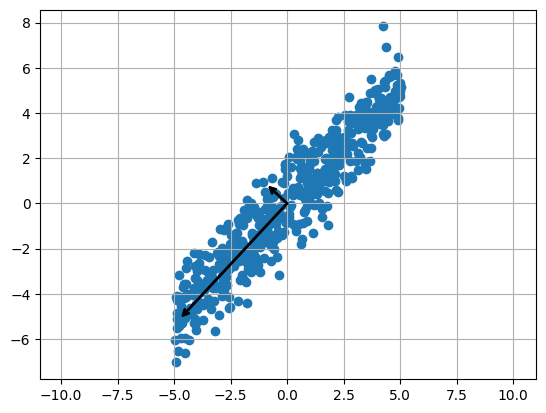

In [53]:
# variable names used in this code : X_centered , my_explained_variance_ratio , sorted_eigVecs (those are the sorted eigenvectors from Step 1.3)
D = sorted_eigVecs.T @ cov_mat @ sorted_eigVecs
my_explained_variance_ratio = np.diagonal(D) / np.trace(D)
print(my_explained_variance_ratio)
plt.scatter(X_centered[:, 0], X_centered[:, 1])
plt.axis('equal');
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

for length, vector in zip(my_explained_variance_ratio, sorted_eigVecs):
    v = vector * 7 * np.sqrt(length) # 7 is an arbitrary factor so the arraows are well fitted in the same figure
    draw_vector( X_centered.mean(axis=0) , X_centered.mean(axis=0) + v)
plt.axis('equal');
plt.grid('on')

**Step 1.5 : Subset of the eigenvectors as basis vectors**

We now perform the core operation of PCA : reducing the dimension of the original space.

This original space is represented by the eigenvector matrix $\boldsymbol{V}$, whose dimension is given by its number of columns $p$.

Reducing the dimension of the original space by PCA boils down to replace this space by a new one, represented by the eigenvector matrix $\boldsymbol{W} = \boldsymbol{V}[:,0:l]$, where $l <  p$ and $\boldsymbol{V}$ has been sorted in order of decreasing eigenvalues. Put in other words, we have created a new eigenvector matrix $\boldsymbol{W}$ keeping only the first $l$ eigenvectors of $\boldsymbol{V}$ with the highest variance. $\boldsymbol{W}$ is called the PCA basis vectors. 

Thus, we have to choose a value of $l$ as small as possible, while achieving a reasonably high value of explained variance. To do so, we will use the cumulated explained variance ratio $cumsum(g_j)$ (with $g_j$ defined in eq. 1.1). This cumulated ratio indeed allows us to estimate $l$ on a percentage basis, as $cumsum(g_{l_W})$ precisely corresponds to the total percentage of explained variance captured by our PCA when using the $l$ eigenvectors of $\boldsymbol{V}$.

Compute two PCA basis vectors $\boldsymbol{W_{90}}$ and $\boldsymbol{W_{99}}$ such that their $l$ dimensions are as small as possible while having a cumulated $g_{l_W}$ ratio respectively above 90 % and 99 %. 

What are the respective dimensions of $\boldsymbol{W_{90}}$ and $\boldsymbol{W_{99}}$ ? Which of $\boldsymbol{W_{90}}$ and $\boldsymbol{W_{99}}$ should be used to reduce **X** dimensionality ?

*tips* : $cumulated(g_{l_W}) = \sum_{j=1}^{l_W} g_j$


In [54]:
cs = np.cumsum(my_explained_variance_ratio)
L90 = sum(cs < 0.9) + 1
L99 = sum(cs < 0.99) + 1

W90 = sorted_eigVecs[:, 0:L90]
W99 = sorted_eigVecs[:, 0:L99]
print("Dimensions of W90 : " + str(W90.shape) + " and dimensions of W99 : " + str(W99.shape))
print(W99)
print(W90)

"""So we need W90 to reduce the dimensionality of X"""

Dimensions of W90 : (2, 1) and dimensions of W99 : (2, 2)
[[-0.68080913 -0.73246087]
 [-0.73246087  0.68080913]]
[[-0.68080913]
 [-0.73246087]]


'So we need W90 to reduce the dimensionality of X'

**Step 1.6 : Projection of original data onto the new basis**

The projection of original data on the PCA basis vectors is done by

$$\textbf{T} = \boldsymbol{\bar{X}} \textbf{W}$$

That is, the first column of $\textbf{T}$  is the projection of the data points onto the first principal component, the second column is the projection onto the second principal component, etc.


Compute the matrices $\boldsymbol{\tilde{X}_{90}}$ and $\boldsymbol{\tilde{X}_{99}}$, projections of the matrix $\textbf{X}$ onto the two basis matrices $\boldsymbol{W_{90}}$ and $\boldsymbol{W_{99}}$. Superimpose in a same plot the original data $\boldsymbol{X}$ and the projected data on the basis matrix $\boldsymbol{W_{99}}$. 



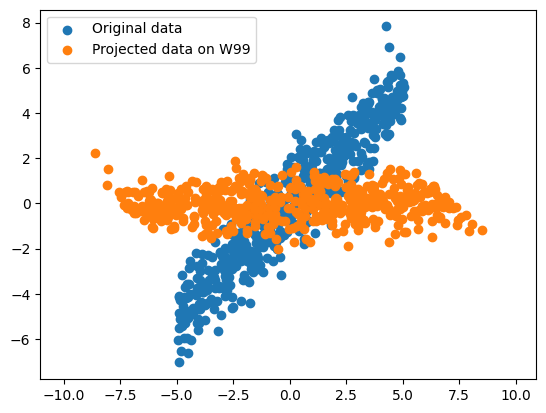

In [55]:
X_new_99 =  X_centered @ W99
X_new_90 =  X_centered @ W90

plt.figure()
plt.scatter(X_centered[:, 0], X_centered[:, 1])
plt.scatter(X_new_99[:, 0], X_new_99[:, 1])
plt.axis('equal');
plt.legend(['Original data', 'Projected data on W99'])

**Step 1.7 : Reconstruction of original data**

This reconstruction is done by

$$\boldsymbol{\bar{X}} = \textbf{T} \textbf{W}^{T}$$

Create two different plots where you will superimpose the original data $\boldsymbol{X}$ and 

-  the reconstruction of original data (i.e. inverse transform) from the basis matrix $\boldsymbol{W_{90}}$ ;

-  the reconstruction of original data (i.e. inverse transform) from the basis matrix $\boldsymbol{W_{99}}$.

Comment results.

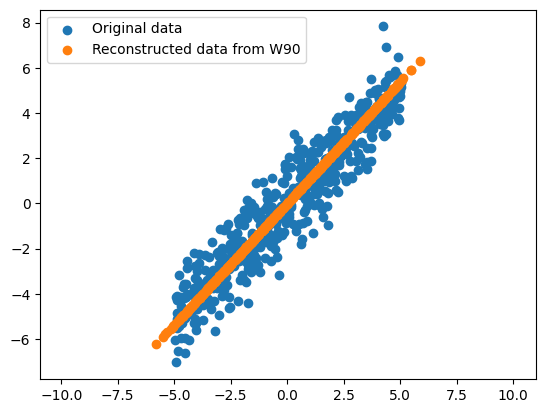

In [56]:
X_reconstructed_90 = X_new_90 @ W90.T
#Affichage de X_reconstructed_90
plt.figure()
plt.scatter(X_centered[:, 0], X_centered[:, 1])
plt.scatter(X_reconstructed_90[:, 0], X_reconstructed_90[:, 1])
plt.axis('equal');
plt.legend(['Original data', 'Reconstructed data from W90'])

**Question 1.1** : using the scikit function `PCA`, recover all your results above. Do you note any difference between implementations ?

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_centered)

# Affichage avec matplotlib:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))
ax[0].scatter(X_centered[:, 0], X_centered[:, 1])
ax[0].scatter(X_new_99[:, 0], X_new_99[:, 1])
ax[0].axis('equal');
ax[0].legend(['Original data', 'Projected data on W99'])

ax[1].scatter(X_centered[:, 0], X_centered[:, 1])
ax[1].scatter(pca.inverse_transform(pca.transform(X_centered))[:, 0], pca.inverse_transform(pca.transform(X_centered))[:, 1])
ax[1].axis('equal');
ax[1].legend(['Original data', 'Reconstructed data from W99'])

"""The results are the same, but the order of the eigenvectors is different. This is not a problem, as the eigenvectors are only defined up to a sign. """



'The results are the same, but the order of the eigenvectors is different. This is not a problem, as the eigenvectors are only defined up to a sign. '

Error in callback <function flush_figures at 0x000001F6838F76D0> (for post_execute):


KeyboardInterrupt: 

**Question 1.2** : we have just dealt with some data where PCA did a great job in reducing their dimensionality, but can you think of new data where this would not be the case ?

# 2. Application of PCA to human face analysis

In the following we will be using the sklearn dataset [```fetch_olivetti_faces```](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html), downloaded as follows:

In [58]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)

print('Personalities in the dataset:',faces.target_names)
print(faces.data.shape)



Personalities in the dataset: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 2914)


**Question 2.1**: using the code cell below, try to estimate empirically a minimal number of PCA axis $l$ so that one can identify unambiguously by eye the 8 different personalities represented in this dataset.

*help* : iteratively reconstruct and plot original faces while increasing the $l$ vaue in your PCA decomposition.

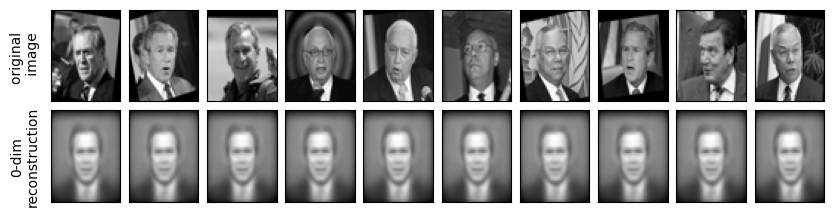

In [68]:
from sklearn.decomposition import PCA

l_w = 0
pca = PCA(n_components=l_w)
pca.fit(faces.data)
X_projected_on_PC = pca.transform(faces.data)
X_reconstructed_after_PCA = pca.inverse_transform(X_projected_on_PC)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(X_reconstructed_after_PCA[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('original \n image')
ax[1, 0].set_ylabel(str(l_w)+'-dim\nreconstruction');

**Question 2.2**: what is the total amount of explained variance with your $l$ number ? To answer this, build a graph that allows us to directly read the minimal number of PCA axis to explain at least a given percentage of the total variance.

*tips* : as done in Step 1.5, take a look at the cumulated explained variance ratio 


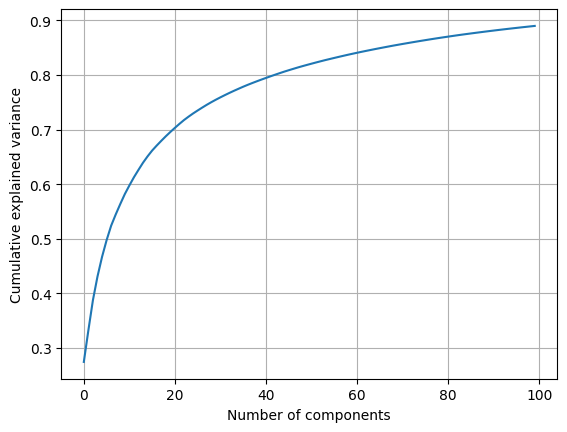

In [65]:
cs = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cs)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.grid('on')

**Question 2.3**: using the script below (fill line 5), compute and plot the first 32 eigenfaces. We define the $j^{th}$ eigenface as the face image composed of (i.e. reshaped from) the $j^{th}$ PCA axis. 

*tips* : plot the absolute value of eigenvectors to better visualize the dimensions of your eigenvectors (i.e. which pixels of your eigenface) that have maximal variance

TypeError: Image data of dtype <U12 cannot be converted to float

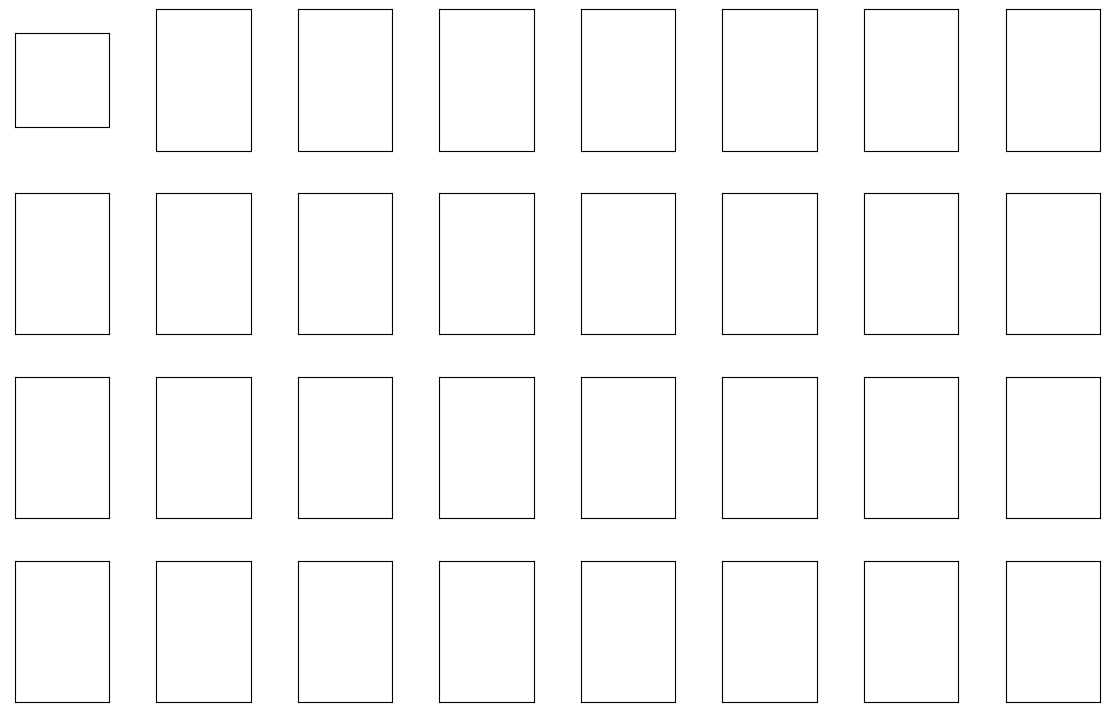

In [66]:
fig, axes = plt.subplots(4,8, figsize=(14, 9),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.3, wspace=0.5))
for i, ax in enumerate(axes.flat):
    nn = ax.imshow( """TO BE FILLED""" , cmap='jet')
    ax.set_title(str(i))
    fig.colorbar(nn,ax=ax)

**Question 2.4**: let's now try better understanding the semantic associated with your different PCA axis.

Below, we provide you a code to visualize the distribution of original faces along two of these axes. Note that this plot has been made interactive (thanks to the `bokeh` library) so you can directly identify the index of each data sample by running your mouse on its marker.

By plotting some original faces (use the second code provided below) selected from the PCA space, are you able to identify some semantic features captured by some PCA axis ?


In [ ]:
# define the two PCA axis you want to visualize
PCA_ax1 = 0
PCA_ax2 = 1

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource, figure, show

output_notebook()

source = ColumnDataSource(data=dict(
    x=X_projected_on_PC[:,PCA_ax1],
    y=X_projected_on_PC[:,PCA_ax2]
    ))

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)")
    ]

p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS)

p.scatter('x', 'y', size=20, source=source)

show(p)

In [ ]:
index_face_1 = 255
index_face_2 = 1097
index_face_3 = 660
index_face_4 = 86

fig, ax = plt.subplots(1,2, figsize=(10, 2.5))
ax[0].imshow(faces.data[index_face_1].reshape(62, 47), cmap='binary_r')
ax[1].imshow(faces.data[index_face_2].reshape(62, 47), cmap='binary_r')

fig, ax = plt.subplots(1,2, figsize=(10, 2.5))
ax[0].imshow(faces.data[index_face_3].reshape(62, 47), cmap='binary_r')
ax[1].imshow(faces.data[index_face_4].reshape(62, 47), cmap='binary_r')
